In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (mean_squared_error, confusion_matrix, classification_report, precision_score, recall_score, roc_auc_score, RocCurveDisplay)

In [4]:
df=pd.read_csv('D:/SRI_STUFF/elevate/data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [5]:
# 1) Strip accidental whitespace in column names
df.columns = df.columns.str.strip()

# 2) Identify columns
target_col = "diagnosis"
id_cols = [c for c in df.columns if c.lower() in {"id"}]
unnamed_cols = [c for c in df.columns if c.lower().startswith("unnamed")]

# 3) Drop id and unnamed columns
df = df.drop(columns=id_cols + unnamed_cols, errors="ignore")

# 4) Standardize the 'concave points' naming if needed (sometimes space vs underscore)
df = df.rename(columns={
    "concave points_mean": "concave_points_mean",
    "concave points_se": "concave_points_se",
    "concave points_worst": "concave_points_worst",
})

# 5) Map target to binary integers
# M = malignant, B = benign in this dataset
df[target_col] = df[target_col].map({"M": 0, "B": 1})

# 6) Split features/target
X = df.drop(columns=[target_col])
y = df[target_col]

print("X shape:", X.shape)
print("y distribution:\n", y.value_counts())
print("Columns kept:\n", list(X.columns)[:10], "... total:", X.shape[1])

X shape: (569, 30)
y distribution:
 diagnosis
1    357
0    212
Name: count, dtype: int64
Columns kept:
 ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean'] ... total: 30


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape

((455, 30), (114, 30))

In [7]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)   # fit on train, transform train
X_test_std  = scaler.transform(X_test)        # transform test with train stats
log_reg = LogisticRegression(
    penalty="l2",
    solver="liblinear",
    max_iter=1000,
    random_state=42
)
log_reg.fit(X_train_std, y_train)
y_pred  = log_reg.predict(X_test_std)
y_proba = log_reg.predict_proba(X_test_std)[:, 1]   

In [8]:
cm = confusion_matrix(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_proba)

print("Confusion matrix:\n", cm)
print(f"Precision: {prec:.3f} | Recall: {rec:.3f} | ROC-AUC: {auc:.3f}")

Confusion matrix:
 [[41  1]
 [ 1 71]]
Precision: 0.986 | Recall: 0.986 | ROC-AUC: 0.996


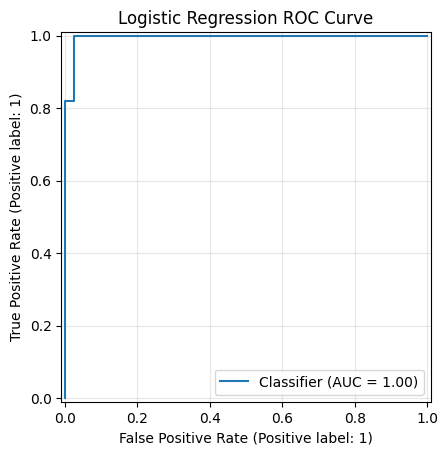

In [9]:
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Logistic Regression ROC Curve")
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
new_threshold = 0.30

# y_proba should be the predicted probabilities for the positive class (e.g., pipe.predict_proba(X_test)[:, 1])
y_pred_tuned = (y_proba >= new_threshold).astype(int)

cm_tuned = confusion_matrix(y_test, y_pred_tuned)
prec_tuned = precision_score(y_test, y_pred_tuned, zero_division=0)
recall_tuned = recall_score(y_test, y_pred_tuned, zero_division=0)

tn, fp, fn, tp = cm_tuned.ravel()
print("Confusion matrix @ threshold =", new_threshold)
print(cm_tuned)
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"Precision: {prec_tuned:.4f} | Recall: {recall_tuned:.4f} ")

Confusion matrix @ threshold = 0.3
[[40  2]
 [ 0 72]]
TN=40, FP=2, FN=0, TP=72
Precision: 0.9730 | Recall: 1.0000 
